## Preparations


### Install kmodes package

In [1]:
%pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Prepare working directory and files

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CISC699/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CISC699


### Import required packages

In [36]:
import numpy as np
import pandas as pd
import fehelper
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from fehelper import encoder, expander, reporter, trainer, visualizer
from kmodes.kprototypes import KPrototypes

RANDOM_SEED = 2022

### Load testing dataset

In [4]:
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

### Data cleaning

In [5]:
def data_cleaning(data=df):
    clean_df = df.copy()
    
    clean_df.drop(columns=['car'], inplace=True)
    na_columns = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
    clean_df.drop(columns=['toCoupon_GEQ5min'], inplace=True)
    frequency_map = {
        'never': 0,
        'less1': 1,
        '1~3': 2,
        '4~8': 3,
        'gt8': 4}
    age_map = {
        'below21': 0,
        '21': 1,
        '26': 2,
        '31': 3,
        '36': 4,
        '41': 5,
        '46': 6,
        '50plus': 7}
    income_map = {
        'Less than $12500': 0,
        '$12500 - $24999': 1,
        '$25000 - $37499': 2,
        '$37500 - $49999': 3,
        '$50000 - $62499': 4,
        '$62500 - $74999': 5,
        '$75000 - $87499': 6,
        '$87500 - $99999': 7,
        '$100000 or More': 8}
    frequency_cols = ['Restaurant20To50', 'RestaurantLessThan20', 
                      'CarryAway', 'CoffeeHouse', 'Bar']
    for col in frequency_cols:
        clean_df[col] = clean_df[col].map(frequency_map)
    clean_df.age = clean_df.age.map(age_map)
    clean_df.income = clean_df.income.map(income_map)
    clean_df.drop(columns=['direction_opp'], inplace=True)
    clean_df['distance'] = None
    clean_df.loc[clean_df['toCoupon_GEQ15min'] == 0, 'distance'] = 0
    clean_df.loc[(clean_df['toCoupon_GEQ15min'] == 1) & \
                 (clean_df['toCoupon_GEQ25min'] == 0), 'distance'] = 1
    clean_df.loc[clean_df['toCoupon_GEQ25min'] == 1, 'distance'] = 2
    clean_df.distance = clean_df.distance.astype('int64')
    clean_df.drop(columns=['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], inplace=True)
    clean_df.has_children = clean_df.has_children.astype(str)
    clean_df.direction_same = clean_df.direction_same.astype(str)
    return clean_df

In [6]:
clean_df = data_cleaning(df)

### Train test split

In [7]:
X = clean_df.drop(columns=['Y'])
y = clean_df.Y
X_train, X_test, y_train, y_test = \
train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.2)

### Two feature engineering settings

Here we want to compare the effects of different feature engineering:

* plan A is to do frequency and target encoding for strong predictors we observed in EDA part, and OneHotEncoding for other categorical features.
* Plan B is to apply OneHotEncoding for all the categorical features.

We will then compare the predictive performances of these two plans and decide which plan to keep for further tasks.

### Plan A

In [8]:
X_train_a = X_train.copy()
X_test_a = X_test.copy()

## Frequency Encoding

In [9]:
strong_predictors = ['destination', 'passanger', 'weather', 'time', 'coupon',
            'expiration', 'maritalStatus', 'education',
            'occupation', 'direction_same']
encoder.freq_encoder(X_train_a, X_test_a, strong_predictors)

In [10]:
X_train_a[['destination', 'destination_freq']].value_counts()

destination      destination_freq
No Urgent Place  0.496699            5040
Work             0.251700            2554
Home             0.251601            2553
dtype: int64

## K-Fold Target Encoding

In [11]:
train_df, test_df = encoder.k_fold_target_encoder(X_train_a, y_train, X_test_a, y_test, strong_predictors)
train_df[['destination', 'destination_target']].value_counts(sort=False)

Correlation between destination_target and Y is 0.13115126234200733.
Correlation between passanger_target and Y is 0.13768972397293727.
Correlation between weather_target and Y is 0.09879814954713537.
Correlation between time_target and Y is 0.11526285485291689.
Correlation between coupon_target and Y is 0.25890622243997125.
Correlation between expiration_target and Y is 0.12967010021027106.
Correlation between maritalStatus_target and Y is 0.06244228374373409.
Correlation between education_target and Y is 0.04462283527392791.
Correlation between occupation_target and Y is 0.06733212568201985.
Correlation between direction_same_target and Y is 0.0007778121240032367.


destination      destination_target
Home             0.496293               530
                 0.504407               511
                 0.507921               533
                 0.510174               489
                 0.511391               490
No Urgent Place  0.633935               997
                 0.634529              1026
                 0.636004               996
                 0.637914               994
                 0.641166              1027
Work             0.503657               503
                 0.504724               543
                 0.504873               502
                 0.504902               514
                 0.505335               492
dtype: int64

Drop the orignal columns to reduce dimensionality.

In [12]:
train_df.drop(columns=strong_predictors, inplace=True)
test_df.drop(columns=strong_predictors, inplace=True)
X_train_a = train_df.drop(columns=['Y'])
X_test_a = test_df.drop(columns=['Y'])

In [13]:
X_train_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10147 entries, 8545 to 4989
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temperature            10147 non-null  int64  
 1   gender                 10147 non-null  object 
 2   age                    10147 non-null  int64  
 3   has_children           10147 non-null  object 
 4   income                 10147 non-null  int64  
 5   Bar                    10061 non-null  float64
 6   CoffeeHouse            9967 non-null   float64
 7   CarryAway              10036 non-null  float64
 8   RestaurantLessThan20   10048 non-null  float64
 9   Restaurant20To50       9995 non-null   float64
 10  distance               10147 non-null  int64  
 11  destination_freq       10147 non-null  float64
 12  passanger_freq         10147 non-null  float64
 13  weather_freq           10147 non-null  float64
 14  time_freq              10147 non-null  float64
 15  

### Other data preprocessing
Here we used sklearn's Pipeline and ColumnTransformer to do simple imputation, standardization, and one hot encoder for columns of mixed data types.

In [14]:
num_features_a = X_train_a.select_dtypes(['int64', 'float64']).columns
cat_features_a = X_train_a.select_dtypes(['object']).columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])
cat_transformer = OneHotEncoder()
preprocessor_a = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features_a),
    ('cat', cat_transformer, cat_features_a)
])
X_train_a = preprocessor_a.fit_transform(X_train_a)
X_test_a = preprocessor_a.transform(X_test_a)

In [15]:
X_train_a.shape, X_test_a.shape

((10147, 33), (2537, 33))

After data preprocessing, we now have 33 features in plan A. Now, we can do data preprocessing for plan B, which basically uses OneHotEncoder for all categorical features.

### Plan B

In [16]:
X_train_b = X_train.copy()
X_test_b = X_test.copy()

In [17]:
num_features_b = X_train_b.select_dtypes(['int64', 'float64']).columns
cat_features_b = X_train_b.select_dtypes(['object']).columns

preprocessor_b = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features_b),
    ('cat', cat_transformer, cat_features_b)
])
X_train_b = preprocessor_b.fit_transform(X_train_b)
X_test_b = preprocessor_b.transform(X_test_b)

In [18]:
X_train_b.shape, X_test_b.shape

((10147, 73), (2537, 73))

After onehot encoding, there are 40 more features in plan B.

## Model Training

The basic models we picked are Logistic Regression, Decision Tree, Naive Bayes, K Nearest Neighbor, and linear Support Vector Machine. We picked those models because they are fast to train. We will use RandomizedSearchCV to choose hyperparameters from the same parameter grid for both plan A and plan B. After that, we will compare the results of them.

### Define classifiers

In [19]:
logreg_clf = LogisticRegression(solver='saga', max_iter=500,
                               random_state=RANDOM_SEED)
dt_clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
bnb_clf = BernoulliNB()
knn_clf = KNeighborsClassifier()
lsvm_clf = LinearSVC(max_iter=5000, dual=False)

### Define hyperparameter searching space

In [20]:
logreg_params = dict(C=loguniform(1e-1, 1e2),
                     penalty=['l1', 'l2'])
dt_params = dict(criterion=['gini', 'entropy'],
                 min_samples_split=[2, 4, 6, 8, 10],
                 max_depth=[2, 4, 6, 8, 10])
bnb_params = dict(alpha=loguniform(1e-1, 1e0))
knn_params = dict(n_neighbors=[2, 4, 6, 8, 10, 12, 14, 20],
               weights=['uniform', 'distance'],
               metric=['euclidean', 'manhattan'])
lsvm_params = dict(C=loguniform(1e-1, 1e2))

In [21]:
clf_list = [logreg_clf, dt_clf, bnb_clf, knn_clf, lsvm_clf]
params_list = [logreg_params, dt_params, bnb_params, knn_params, lsvm_params]
model_names = ['Logistic Regression', 'Decison Tree', 'Bernoulli Naive Bayes',
               'KNN Classifier', 'Linear SVM']
model_suffix_a = ['_logreg_a', '_dt_a', '_bnb_a', '_knn_a', '_lsvm_a']

In [22]:
def train_models(X, y, model_suffix, clf_list, params_list, method='random'):
    """
    This function train multiple models using cross validation randomized search or grid search,
    then store the validation result and the best models.

    :param X: training set of X
    :param y: training set of y
    :param model_suffix: the list of suffixes for each model
    :param clf_list: the list of models/classifiers corresponding to model suffixes
    :param params_list: the list of hyperparameter searching spaces for models in the list
    :param method: hyperparameter search method: "random" or "grid", notice the "random" method
                   requires a RANDOM_SEED to be set in the global environment
    :return:
    """
    if method == 'random':
        for i in range(len(clf_list)):
            # model training with RandomizedSearchCV
            rscv = RandomizedSearchCV(estimator=clf_list[i],
                                      param_distributions=params_list[i],
                                      n_jobs=-1, random_state=RANDOM_SEED).fit(X, y)
            # store cv results
            globals()['rscv%s' % model_suffix[i]] = pd.DataFrame(rscv.cv_results_)
            # store the best model
            globals()['best%s' % model_suffix[i]] = rscv
            print("rscv", model_suffix[i], " is trained", sep='')
    if method == 'grid':
        for i in range(len(clf_list)):
            # model training with GridSearchCV
            gscv = GridSearchCV(estimator=clf_list[i],
                                param_grid=params_list[i],
                                cv=5).fit(X, y)
            # store cv results
            globals()['gscv%s' % model_suffix[i]] = pd.DataFrame(gscv.cv_results_)
            # store the best model
            globals()['best%s' % model_suffix[i]] = gscv
            print("gscv", model_suffix[i], " is trained", sep='')

In [23]:
train_models(X_train_a, y_train, model_suffix_a, clf_list, params_list)

rscv_logreg_a is trained
rscv_dt_a is trained
rscv_bnb_a is trained
rscv_knn_a is trained
rscv_lsvm_a is trained


### Record results

In [24]:
def report_results(model_list, model_suffix):
    """
    Store the best validation results into a dataframe.

    :param model_list: the list of models
    :param model_suffix: the list of model suffixes
    :return:
    """
    for i in range(len(model_list)):
        globals()['df%s' % model_suffix[i]] = model_list[i].query('rank_test_score == 1')\
        [['params', 'mean_test_score', 'std_test_score']]

### Model evaluation

In [25]:
# record best results in cross validation
rscv_list_a = [rscv_logreg_a, rscv_dt_a, rscv_bnb_a, rscv_knn_a, rscv_lsvm_a]
report_results(rscv_list_a, model_suffix_a)

# output the best results as a dataframe
df_list_a = [df_logreg_a, df_dt_a, df_bnb_a, df_knn_a, df_lsvm_a]
for df, model in zip(df_list_a, model_names):
    df['model'] = model
result_df_a = pd.concat(df_list_a)

# check test scores
best_clfs_a = [best_logreg_a, best_dt_a, best_bnb_a, best_knn_a, best_lsvm_a]
test_result_a = reporter.evaluate_models(best_clfs_a, model_names, X_test_a, y_test)

In [26]:
result_df_a

,params,mean_test_score,std_test_score,model
9,"{'C': 0.9633705617464074, 'penalty': 'l1'}",0.679906,0.012816,Logistic Regression
1,"{'min_samples_split': 8, 'max_depth': 6, 'crit...",0.697644,0.011213,Decison Tree
6,"{'min_samples_split': 2, 'max_depth': 6, 'crit...",0.697644,0.011213,Decison Tree
0,{'alpha': 0.10217828612167441},0.647876,0.008028,Bernoulli Naive Bayes
1,{'alpha': 0.3155424627894703},0.647876,0.008028,Bernoulli Naive Bayes
2,{'alpha': 0.12983258076672588},0.647876,0.008028,Bernoulli Naive Bayes
3,{'alpha': 0.11219513311553655},0.647876,0.008028,Bernoulli Naive Bayes
4,{'alpha': 0.4846269865430348},0.647876,0.008028,Bernoulli Naive Bayes
5,{'alpha': 0.3068937671397086},0.647876,0.008028,Bernoulli Naive Bayes
6,{'alpha': 0.7900548190172948},0.647876,0.008028,Bernoulli Naive Bayes


In [27]:
test_result_a

,model,test_acc,f1_score
0,Logistic Regression,0.675995,0.725267
1,Decison Tree,0.691762,0.733651
2,Bernoulli Naive Bayes,0.646039,0.693306
3,KNN Classifier,0.718171,0.766569
4,Linear SVM,0.671265,0.720322


### Visualize the results

In [28]:
visualizer.plot_results([test_result_a], ['plan A'], result='accuracy')

### Plan B

Train those models again on data of plan B:

In [29]:
model_suffix_b = ['_logreg_b', '_dt_b', '_bnb_b', '_knn_b', '_lsvm_b']
train_models(X_train_b, y_train, model_suffix_b, clf_list, params_list)

# record best results in cross validation
rscv_list_b = [rscv_logreg_b, rscv_dt_b, rscv_bnb_b, rscv_knn_b, rscv_lsvm_b]
report_results(rscv_list_b, model_suffix_b)

# output the best results as a dataframe
df_list_b = [df_logreg_b, df_dt_b, df_bnb_b, df_knn_b, df_lsvm_b]
for df, model in zip(df_list_b, model_names):
    df['model'] = model
result_df_b = pd.concat(df_list_b)

# check test scores
best_clfs_b = [best_logreg_b, best_dt_b, best_bnb_b, best_knn_b, best_lsvm_b]
test_result_b = reporter.evaluate_models(best_clfs_b, model_names, X_test_b, y_test)

rscv_logreg_b is trained
rscv_dt_b is trained
rscv_bnb_b is trained


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



rscv_knn_b is trained
rscv_lsvm_b is trained


In [30]:
result_df_b

,params,mean_test_score,std_test_score,model
9,"{'C': 0.9633705617464074, 'penalty': 'l1'}",0.683553,0.014708,Logistic Regression
6,"{'min_samples_split': 2, 'max_depth': 6, 'crit...",0.696266,0.012518,Decison Tree
6,{'alpha': 0.7900548190172948},0.655563,0.012332,Bernoulli Naive Bayes
8,{'alpha': 0.7887931360528659},0.655563,0.012332,Bernoulli Naive Bayes
9,{'alpha': 0.5261807179194276},0.655563,0.012332,Bernoulli Naive Bayes
5,"{'weights': 'distance', 'n_neighbors': 20, 'me...",0.721298,0.006093,KNN Classifier
3,{'C': 0.14122840506833556},0.681287,0.014860,Linear SVM


In [31]:
test_result_b

,model,test_acc,f1_score
0,Logistic Regression,0.672054,0.722667
1,Decison Tree,0.680725,0.740051
2,Bernoulli Naive Bayes,0.661411,0.705317
3,KNN Classifier,0.735120,0.780249
4,Linear SVM,0.671265,0.721070


In [32]:
visualizer.plot_results([test_result_a, test_result_b], ['plan A', 'plan B'], result='accuracy')

In [33]:
visualizer.plot_results([test_result_a, test_result_b], ['plan A', 'plan B'], result='f1_score')

## K-Prototypes Feature Expansion

To use k-prototypes, we need to point out the column indices of categorical features. After using sklearn's preprocessor, the column names and indices have changed. So, we need to figure them out for data plan A.

In [35]:
scale_features_a = list(preprocessor_a.transformers_[0][2])
onehot_features_a = list(preprocessor_a.transformers_[1][1].get_feature_names_out(list(cat_features_a)))
onehot_indices_a = list(range(len(preprocessor_a.transformers_[0][2]), 
                                  X_train_a.shape[1]))

### Silhouette diagram
To determine which number of clusters to use in the K-prototypes clustering, we plotted a silhouette diagram:

In [37]:
train_kprot_a = np.hstack((X_train_a, y_train[:, np.newaxis]*5.0))
kprot_runs_a = [KPrototypes(n_clusters=k, random_state=RANDOM_SEED, n_jobs=-1).\
                fit(train_kprot_a, categorical=onehot_indices_a)
                for k in range(1, 11)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



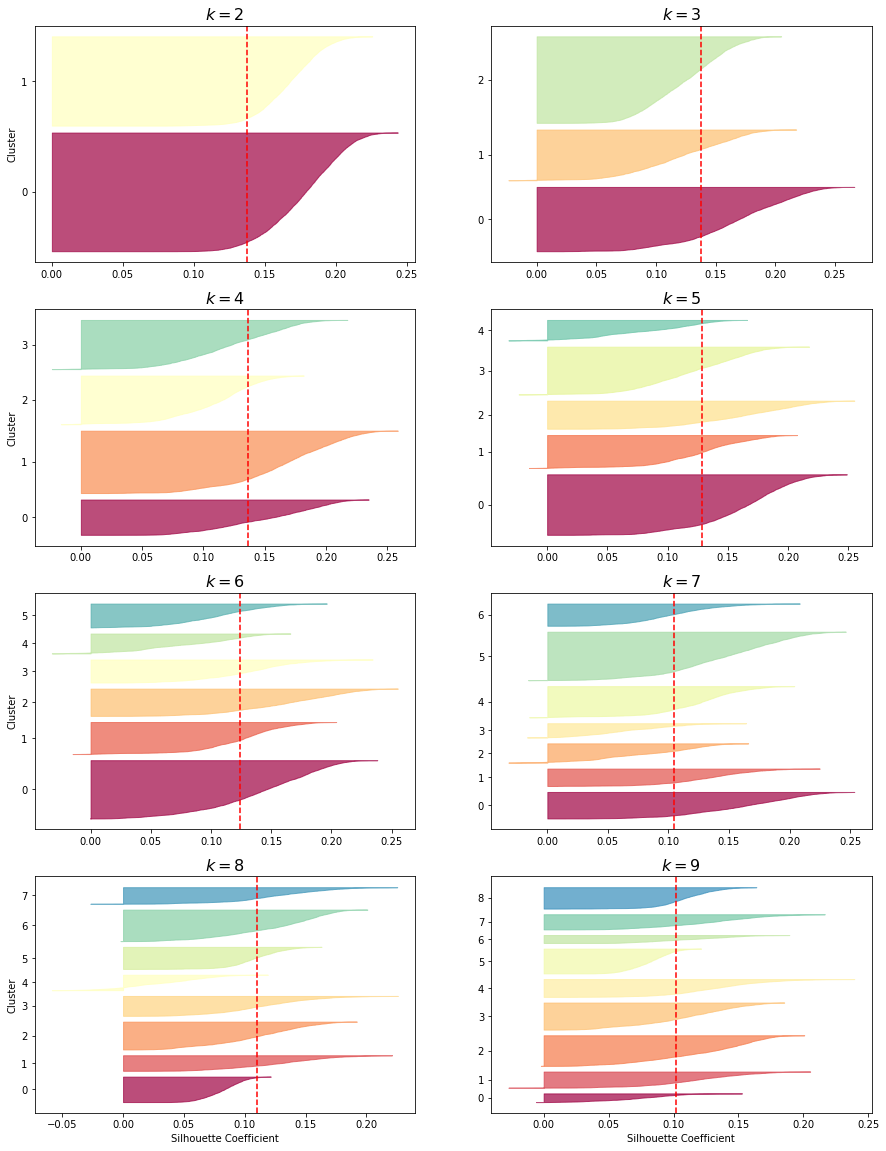

In [38]:
visualizer.silhouette_diagram(train_kprot_a, kprot_runs_a)

According to the silhouette plot for data plan A, the silhouette score looks good when  k
=
2
,
3
,
4
,
5
  as the red dashed line indicates the average silhouette score. We are picking  k
=
4
  as the number of clusters of our k-prototypes clustering for data in plan A.

In [39]:
kprot_a = expander.KProtExpander(k=4, target_scale=5.0, 
                                 categorical=onehot_indices_a,
                                 random_state=RANDOM_SEED)
train_cluster_a = kprot_a.fit_transform(X_train_a, y_train)
test_cluster_a = kprot_a.transform(X_test_a)
# use one-hot encoder to record the cluster labels
enc = OneHotEncoder()
# Notice that after one-hot encoding, the outcome matrix
# is a sparse matrix, we need to transform to an ndarray
train_cluster_label_a = enc.fit_transform(train_cluster_a).toarray()
test_cluster_label_a = enc.transform(test_cluster_a).toarray()
X_train_kprot_a = np.hstack((X_train_a, train_cluster_label_a))
X_test_kprot_a = np.hstack((X_test_a, test_cluster_label_a))

/content/drive/MyDrive/CISC699/fehelper/expander/_k_prot_expander.py:41: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



### Model training after feature expansion

In [41]:
model_suffix_kprot = ['_logreg_kprot', '_dt_kprot', '_bnb_kprot', '_knn_kprot', '_lsvm_kprot']
train_models(X_train_kprot_a, y_train, model_suffix_kprot, clf_list, params_list)

# record best results in cross validation
rscv_list_kprot = [rscv_logreg_kprot, rscv_dt_kprot, rscv_bnb_kprot, rscv_knn_kprot, rscv_lsvm_kprot]
report_results(rscv_list_kprot, model_suffix_kprot)

# output the best results as a dataframe
df_list_kprot = [df_logreg_kprot, df_dt_kprot, df_bnb_kprot, df_knn_kprot, df_lsvm_kprot]
for df, model in zip(df_list_kprot, model_names):
    df['model'] = model
result_df_kprot = pd.concat(df_list_kprot)

# check test scores
best_clfs_kprot = [best_logreg_kprot, best_dt_kprot, best_bnb_kprot, best_knn_kprot, best_lsvm_kprot]
test_result_kprot = reporter.evaluate_models(best_clfs_kprot, model_names, X_test_kprot_a, y_test)

rscv_logreg_kprot is trained
rscv_dt_kprot is trained
rscv_bnb_kprot is trained


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



rscv_knn_kprot is trained
rscv_lsvm_kprot is trained


In [42]:
result_df_kprot

,params,mean_test_score,std_test_score,model
9,"{'C': 0.9633705617464074, 'penalty': 'l1'}",0.678428,0.012754,Logistic Regression
1,"{'min_samples_split': 8, 'max_depth': 6, 'crit...",0.695081,0.006674,Decison Tree
6,"{'min_samples_split': 2, 'max_depth': 6, 'crit...",0.695081,0.006674,Decison Tree
0,{'alpha': 0.10217828612167441},0.639795,0.007093,Bernoulli Naive Bayes
1,{'alpha': 0.3155424627894703},0.639795,0.007093,Bernoulli Naive Bayes
2,{'alpha': 0.12983258076672588},0.639795,0.007093,Bernoulli Naive Bayes
3,{'alpha': 0.11219513311553655},0.639795,0.007093,Bernoulli Naive Bayes
4,{'alpha': 0.4846269865430348},0.639795,0.007093,Bernoulli Naive Bayes
5,{'alpha': 0.3068937671397086},0.639795,0.007093,Bernoulli Naive Bayes
6,{'alpha': 0.7900548190172948},0.639795,0.007093,Bernoulli Naive Bayes


In [43]:
test_result_kprot

,model,test_acc,f1_score
0,Logistic Regression,0.672054,0.722111
1,Decison Tree,0.693339,0.744751
2,Bernoulli Naive Bayes,0.637367,0.675828
3,KNN Classifier,0.722901,0.772271
4,Linear SVM,0.670477,0.720401


### Visualize the results

In [44]:
visualizer.plot_results([test_result_a, test_result_b, test_result_kprot], 
                        ['plan A', 'plan B', 'Feature Expansion'], 
                        result='accuracy')

In [45]:
visualizer.plot_results([test_result_a, test_result_b, test_result_kprot], 
                        ['plan A', 'plan B', 'Feature Expansion'], 
                        result='f1_score')